# Set up

In [107]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
train_path = 'nbs/cats-and-dogs/train'
valid_path = 'nbs/cats-and-dogs/valid'
test_path = 'nbs/cats-and-dogs/test'

In [109]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)

Found 40 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [110]:
train_batches

In [111]:
# plot images with label wthin jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=10)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [112]:
imgs, labels = next(train_batches)

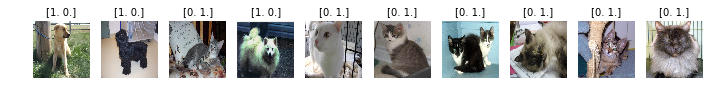

In [113]:
plots(imgs, titles=labels)

# Build and train CNN

In [114]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    Flatten(),
    Dense(2, activation='softmax'),
])

In [115]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 2s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 2s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 2s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 2s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 2s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


# Predict 

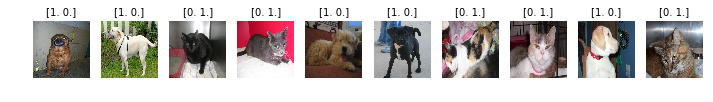

In [117]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [118]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 0., 1., 1., 0., 0., 1., 0.], dtype=float32)

In [119]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [120]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [121]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [122]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 5]
 [0 5]]


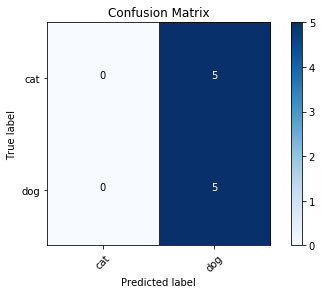

In [123]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Build Fine-tuned VGG16 model

In [124]:
vgg16_model = keras.applications.vgg16.VGG16()

In [125]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [126]:
type(vgg16_model)

keras.engine.training.Model

In [127]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [128]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [129]:
for layer in model.layers:
    layer.trainable = False

In [130]:
model.add(Dense(2, activation='softmax'))

In [131]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Train the fine-tuned VGG16 model

In [132]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [133]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 26s - loss: 0.7896 - acc: 0.6500 - val_loss: 0.4773 - val_acc: 0.7500
Epoch 2/5
 - 27s - loss: 0.5713 - acc: 0.7750 - val_loss: 0.4158 - val_acc: 0.6875
Epoch 3/5
 - 27s - loss: 0.4117 - acc: 0.8250 - val_loss: 0.3870 - val_acc: 0.7500
Epoch 4/5
 - 27s - loss: 0.2999 - acc: 0.8500 - val_loss: 0.3519 - val_acc: 0.7500
Epoch 5/5
 - 27s - loss: 0.2045 - acc: 0.9250 - val_loss: 0.3365 - val_acc: 0.8125


#  Predict using fine-tuned VGG16 model

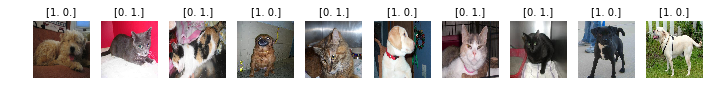

In [134]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [135]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 1., 0., 1., 0., 0., 1., 1.], dtype=float32)

In [136]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [137]:
predictions
np.around(predictions[:,0])

array([0., 0., 1., 1., 0., 1., 0., 0., 1., 1.], dtype=float32)

In [138]:
cm = confusion_matrix(test_labels, np.around(predictions[:,0]))

Confusion matrix, without normalization
[[4 1]
 [1 4]]


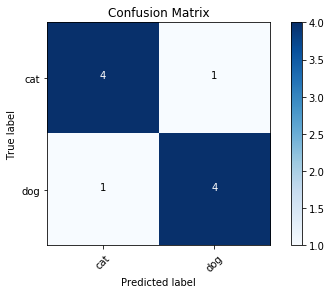

In [139]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Save model

In [140]:
model.save('VGG16_cats_and_dogs.h5')